In [1]:
import sys
sys.path.append("..")

import warnings
from pathlib import Path

import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.linalg as npl
import math
import random

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch

from nilearn import signal
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance, GroupSparseCovarianceCV

from bold_dementia.data.study import make_control_idx
from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices


CACHE_DIR = "/georges/memento/BIDS/derivatives/schaeffer/"

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"

random.seed(1)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


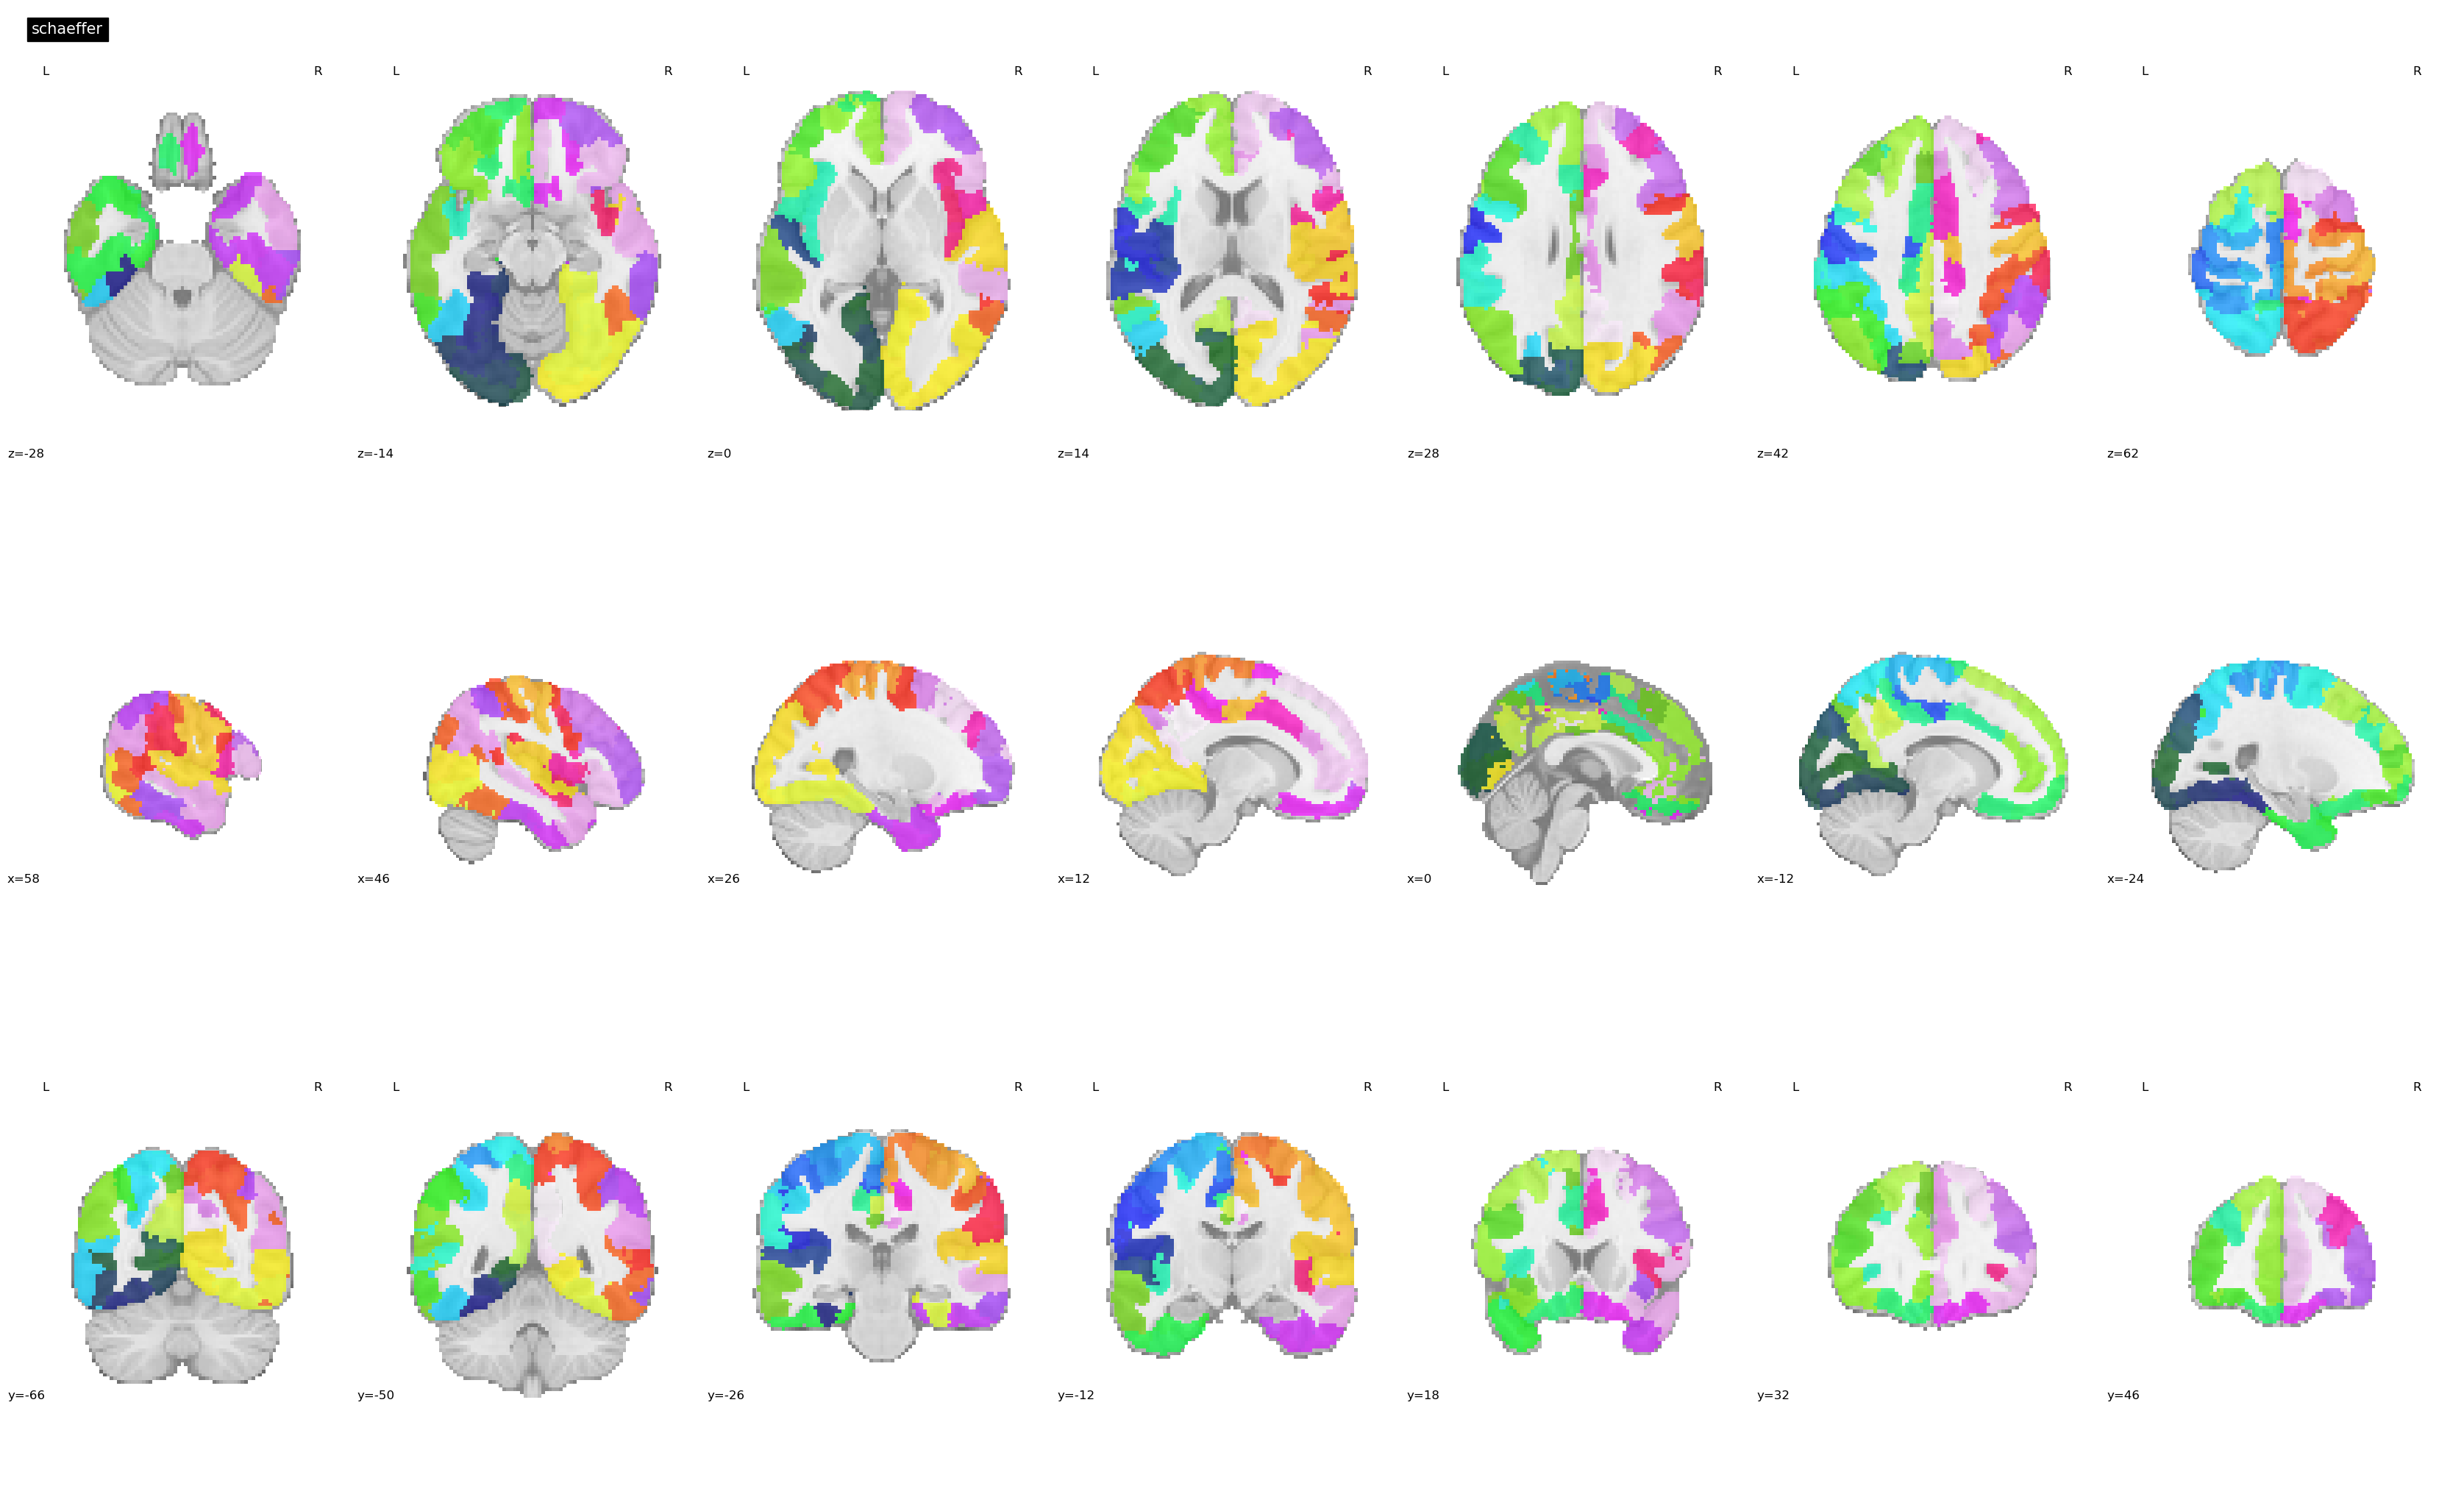

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot(display_mode="mosaic")
plotting.show()

In [3]:
def days_to_onset(row):
    return row.scan_to_onset

memento = MementoTS(cache_dir=CACHE_DIR, target_func=lambda row: row)

res = next(iter(memento))
res

(array([[662.8475 , 647.64514, 670.0993 , ..., 877.73083, 882.3985 ,
         913.4702 ],
        [658.8802 , 642.1198 , 660.2319 , ..., 871.4786 , 885.58026,
         910.0192 ],
        [656.66705, 643.5157 , 659.10895, ..., 869.2196 , 884.5311 ,
         900.2189 ],
        ...,
        [659.4836 , 647.7854 , 669.7048 , ..., 872.0773 , 886.2803 ,
         910.8693 ],
        [653.1279 , 647.9702 , 663.46655, ..., 867.3978 , 892.3242 ,
         912.53314],
        [654.3256 , 640.2316 , 662.6041 , ..., 869.99915, 888.7917 ,
         911.5599 ]], dtype=float32),
 index                                                                0
 file_path            /georges/memento/BIDS/derivatives/fmriprep-23....
 file_basename        sub-0001_ses-M000_task-rest_space-MNI152NLin6A...
 file_tag                                                          bold
 file_type                                                       nii.gz
 file_fields             ['sub', 'ses', 'task', 'space', 'res', 'desc'

In [4]:
def load_signals(dataset, confounds_strategy, is_pos_func, is_neg_func):
    i = 0
    pos_ts = []
    neg_ts = []
    pos_meta = []
    neg_meta = []
    for ts, row, fpath in iter(dataset):
        confounds, sample_mask = load_confounds(
            fpath, **confounds_strategy
        )
        with warnings.catch_warnings(action="ignore", category=DeprecationWarning):
            cleaned_ts = signal.clean(
                ts,
                sample_mask=sample_mask,
                confounds=confounds,
                standardize="zscore_sample"
            )
        if is_pos_func(row):
            pos_ts.append(cleaned_ts)
            pos_meta.append(row)
        elif is_neg_func(row):
            neg_ts.append(cleaned_ts)
            neg_meta.append(row)

    pos_meta = pd.DataFrame(pos_meta).reset_index(drop=True).drop("index", axis=1)
    neg_meta = pd.DataFrame(neg_meta).reset_index(drop=True).drop("index", axis=1)
    return pos_ts, neg_ts, pos_meta, neg_meta
            
    

In [5]:
def balance_control(pos, control, tol=1):
    gap = pos.AGE_CONS.mean() - control.AGE_CONS.mean()
    # Usually the age is lower in control group
    while gap > tol:
        idx_to_drop = control.AGE_CONS.idxmin()
        print(control.loc[idx_to_drop, "AGE_CONS"], end=", new gap = ")
        control = control.drop(idx_to_drop)

        if len(control) <= len(pos):
            raise ValueError("Removed too many subjects from control")
        gap = pos.AGE_CONS.mean() - control.AGE_CONS.mean()
        print(gap)

    return pos, control
        

In [6]:
from bold_dementia.data.memento import past_diag

def healthy_control(row):
    return math.isnan(row.scan_to_onset)

AD_signals, control_signals, pm, nm = load_signals(memento, confounds_strategy, past_diag, healthy_control)

In [8]:
_, balanced_meta = balance_control(pm, nm)
balanced_signals = [control_signals[idx] for idx in balanced_meta.index]

38.3, new gap = 3.6200834958040247
38.3, new gap = 3.6040507161106348
38.3, new gap = 3.588001951592048
39.8, new gap = 3.5726853080065837
39.8, new gap = 3.5573533783496885
41.2, new gap = 3.5427050912992257
43.2, new gap = 3.529041171594372
43.2, new gap = 3.5153635947983446
43.2, new gap = 3.5016723404255288
44.4, new gap = 3.48856768809938
44.4, new gap = 3.4754499180031075
44.4, new gap = 3.4623190104305337
44.4, new gap = 3.44917494563596
44.4, new gap = 3.436017703834054
46.1, new gap = 3.4236998228728766
46.2, new gap = 3.4114197563813775
46.2, new gap = 3.399127360505844
46.2, new gap = 3.386822616668624
47.4, new gap = 3.3751085213300485
47.4, new gap = 3.363382647112303
47.4, new gap = 3.351644976240422
47.6, new gap = 3.3399961451562916
47.6, new gap = 3.328335583124442
47.6, new gap = 3.316663272415454
47.6, new gap = 3.3049791952642664
47.6, new gap = 3.293283333869809
47.7, new gap = 3.2816261244820595
47.7, new gap = 3.269957146079264
47.7, new gap = 3.258276380829585
4

In [9]:
# Merge series but keep track of indices
time_series = AD_signals + balanced_signals
AD_indices = list(range(len(AD_signals)))
control_indices = list(range(len(AD_signals), len(time_series)))
n = len(time_series)
print(f"Study on {n} subjects")

Study on 1794 subjects


In [10]:
from sklearn import covariance
from bold_dementia.models.transformers import ListMixin, Concatenator
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


# (if we can still use GroupSparseCovariance as estimator)
# Or maybe give Ledoit Wolf another chance

# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity

# TODO Add reorganisation layer to put in ConnectivityMeasure format
#pipe = Pipeline(
#    [
#        ("scaler", ListScaler()),
#        ("cov", GroupSparseCovariance(alpha=0.0011)), # alpha found by CV
#    ]
#)
pipe = ConnectivityMeasure(
    covariance.LedoitWolf(),
    kind="covariance")

# Fit AD and controls together to have a common sparsity pattern,
# but is that a good idea?
c = pipe.fit_transform(time_series)




In [11]:

# Use Bunch for compatibility with pipelines
gcov = Bunch(
    covariances_=c,
    precisions_=npl.inv(c) # I don't like this
)

In [12]:

#gcov = pipe.named_steps["cov"]
AD_cov = gcov.covariances_[AD_indices, :, :].mean(axis=0)
AD_prec = gcov.precisions_[AD_indices, :, :].mean(axis=0)

control_cov = gcov.covariances_[control_indices, :, :].mean(axis=0)
control_prec = gcov.precisions_[control_indices, :, :].mean(axis=0)

In [13]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

def plot_matrices(cov, prec, title, labels, macro_labels=True):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        n_regions = len(labels)
        labels = None
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax1.vlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic")
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic", vmin=-span, vmax=span)

    # This is a bit unstatisfying
    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
        ax1.set_xticklabels(lbls, rotation=30)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return fig

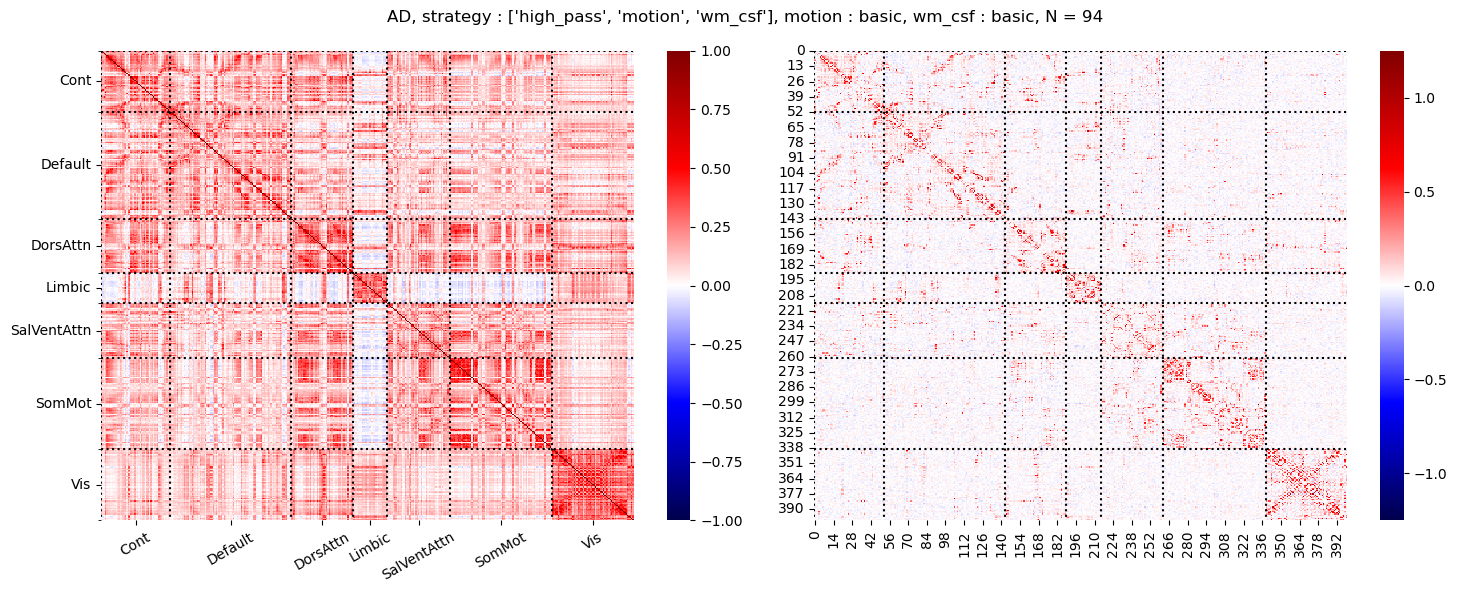

In [14]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_signals)}", atlas.labels, macro_labels=True)

plotting.show()

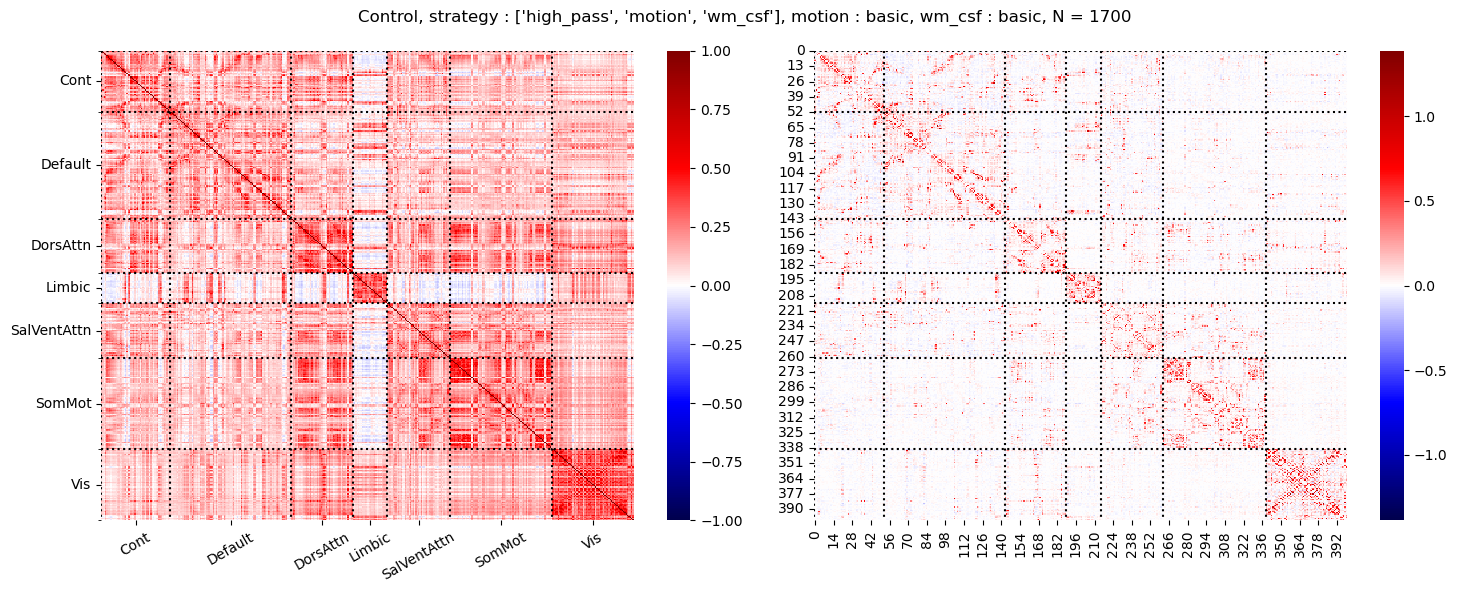

In [15]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(balanced_signals)}", atlas.labels, macro_labels=True)

plotting.show()

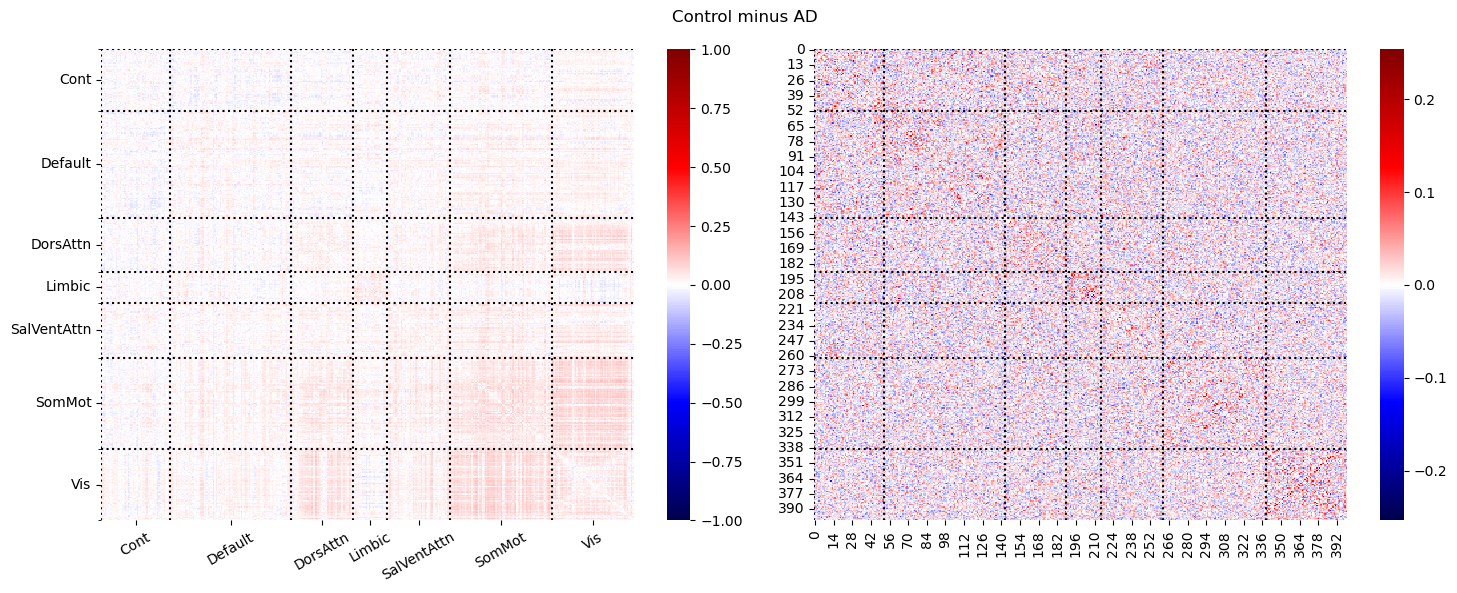

In [16]:
# TODO Same pipeline but shufle time series at the beginning to compare
# TODO Control for age?
plot_matrices(
    control_cov - AD_cov,
    -control_prec + AD_prec,
    "Control minus AD",
    atlas.labels,
    macro_labels=True
)
plotting.show()

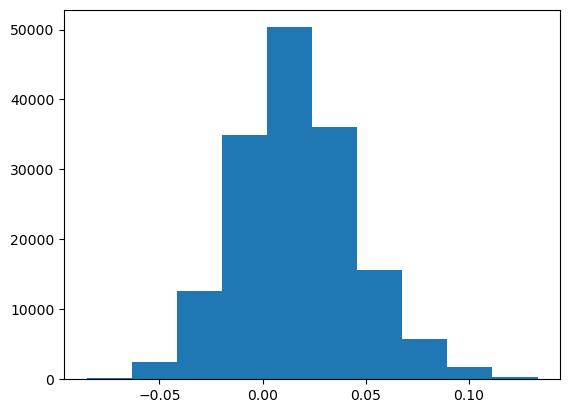

In [17]:
diff = control_cov - AD_cov
plt.hist(diff.flatten())
plt.show()